In [1]:
#s3_data ="s3://aegovan-data/test_unique_pub_v3_lessnegatve_predicted_linear.json"
data_dir = "temp"

In [12]:
!rm -rf $data_dir
!mkdir $data_dir
!aws s3 cp s3://aegovan-data/results/model_PpiNoInteractionDataset_CnnPos_190913_0058 $data_dir --recursive --exclude "*"  --include "*.json" --exclude "*vocab.json" --include "*.log"

download: s3://aegovan-data/results/model_PpiNoInteractionDataset_CnnPos_190913_0058/training_scores_epoch_Objectdump_20190913_190439_aab1a949-6da1-41dc-b4d6-58cb8a8c372c.json to temp/training_scores_epoch_Objectdump_20190913_190439_aab1a949-6da1-41dc-b4d6-58cb8a8c372c.json
download: s3://aegovan-data/results/model_PpiNoInteractionDataset_CnnPos_190913_0058/validation_scores_epoch_Objectdump_20190913_190439_4473a48e-ebdc-40a8-905d-6568405148ad.json to temp/validation_scores_epoch_Objectdump_20190913_190439_4473a48e-ebdc-40a8-905d-6568405148ad.json
download: s3://aegovan-data/results/model_PpiNoInteractionDataset_CnnPos_190913_0058/run.log to temp/run.log
download: s3://aegovan-data/results/model_PpiNoInteractionDataset_CnnPos_190913_0058/predicted_val_unique_negative_entity_only.json to temp/predicted_val_unique_negative_entity_only.json
download: s3://aegovan-data/results/model_PpiNoInteractionDataset_CnnPos_190913_0058/predicted_test_unique_negative_entity_only.json to temp/predicted

In [13]:
!ls  $data_dir

predicted_test_unique_negative_entity_only.json
predicted_val_unique_negative_entity_only.json
run.log
training_scores_epoch_Objectdump_20190913_190439_aab1a949-6da1-41dc-b4d6-58cb8a8c372c.json
validation_scores_epoch_Objectdump_20190913_190439_4473a48e-ebdc-40a8-905d-6568405148ad.json


In [14]:
!head -1 $data_dir/run.log 

commit 7b9fa370926b5c0b5c8c2baa9f2e8ef9522042d6


In [15]:
!head -10 $data_dir/run.log | tail -8

Date:   Fri Sep 13 10:37:17 2019 +1000

    Add no interaction dataset
{'dataset': 'PpiNoInteractionDataset', 'trainjson': '/data/train_unique_negative_entity_only.json', 'valjson': '/data/val_unique_negative_entity_only.json', 'embedding': '/data/wikipedia-pubmed-and-PMC-w2v.bin.txt', 'embeddim': 200, 'outdir': '/data/model_PpiNoInteractionDataset_CnnPos_190913_0058', 'epochs': 200, 'interaction_type': None, 'log_level': 'INFO'}
2019-09-13 00:58:31,530 - __main__ - INFO - The embedding header is 5443656 200

2019-09-13 00:58:31,531 - algorithms.RelationExtractorBiLstmNetwork - INFO - The text feature is index 0, the feature lengths are [250   1   1]
2019-09-13 00:58:31,531 - algorithms.RelationExtractorBiLstmNetwork - INFO - Word embedding size is 200, pos embedding size is 6, totaldim is 206, hidden_size  100


In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

In [17]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)



In [22]:
import glob

results_file = "./temp/predicted_val_unique_negative_entity_only.json"
validation_fit_file = glob.glob("temp/validation_scores_epoch_Objectdump*.json")[0]
train_fit_file = glob.glob("temp/training_scores_epoch_Objectdump*.json")[0]


pos_label = True

In [19]:
#download_single_file(s3_data, results_file)

In [23]:
import pandas as pd

In [24]:
df_results = pd.read_json(results_file)
df_results["actual"] = df_results["isValid"]

In [25]:
df_results.columns


Index(['entityMentionsCount', 'hasTriggerWord', 'interactionId',
       'interactionType', 'isValid', 'lessThanThreshold', 'participant1Alias',
       'participant1Id', 'participant2Alias', 'participant2Id',
       'participants_count', 'pubmedId', 'pubmedTitle', 'pubmedabstract',
       'normalised_abstract', 'particpant1Exists', 'particpant2Exists',
       'bothParticpantsExist', 'noParticpantsExist', 'predicted',
       'confidence_scores', 'confidence_true', 'confidence_false', 'actual'],
      dtype='object')

## Analyse Results

In [26]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [27]:
df = df_results

In [28]:
df_results.shape

(421, 24)

In [29]:
import math

# This is log softmax, convert to softmax prob
df["true"]  =df["confidence_scores"].apply(lambda x: math.exp(x["True"]))
df["false"]  =df["confidence_scores"].apply(lambda x: math.exp(x["False"]))

df[ ["true", "false", "actual", "predicted", "confidence_scores"]].sort_values(["true"], ascending=False).head(n=3)

,true,false,actual,predicted,confidence_scores
317,4.248389,0.805638,True,True,"{'False': -0.2161206454, 'True': 1.4465398788}"
340,3.371938,0.783656,True,True,"{'False': -0.24378484490000002, 'True': 1.2154875994}"
87,3.312355,0.757889,False,True,"{'False': -0.2772189379, 'True': 1.1976593733}"


In [30]:
df['fake_interactionType'] = df['interactionId'].str.contains('fake_interaction')
df['fake_entitypair'] = df['interactionId'].str.contains('fake_annot')

The accuracy is 0.8291139240506329


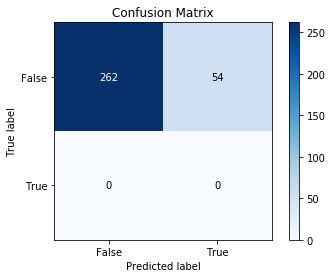

In [31]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
fake = df.query('fake_entitypair')

accuracy = accuracy_score(fake["actual"], fake["predicted"], sample_weight=None)
print("The accuracy is {}".format( accuracy))

import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(fake["actual"], fake["predicted"], normalize=False )
plt.show()

The accuracy is nan


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/matplotlib/image.py:863: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.5, right=-0.5
  self.axes.set_xlim((xmin, xmax), auto=None)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/matplotlib/image.py:865: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.5, top=-0.5
  self.axes.set_ylim((ymin, ymax), auto=None)


ValueError: zero-size array to reduction operation maximum which has no identity

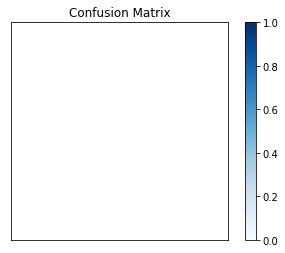

In [32]:
fake = df.query('fake_interactionType')

accuracy = accuracy_score(fake["actual"], fake["predicted"], sample_weight=None)
print("The accuracy is {}".format( accuracy))


import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(fake["actual"], fake["predicted"], normalize=False )
plt.show()

In [33]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df["actual"], df["predicted"], sample_weight=None)  
accuracy = accuracy_score(df["actual"], df["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))



The F1 score is 0.611353711790393 and the accuracy is 0.7885985748218527


In [34]:
!pip install scikit-plot==0.3.7

awsebcli 3.12.4 has requirement requests<=2.9.1,>=2.6.1, but you'll have requests 2.18.4 which is incompatible.
spacy 2.1.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.1 which is incompatible.
blis 0.2.4 has requirement numpy>=1.15.0, but you'll have numpy 1.14.1 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


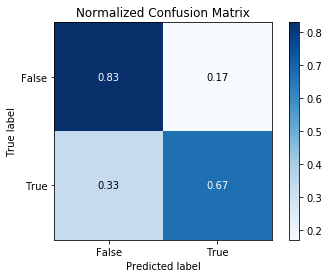

In [35]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=True )
plt.show()

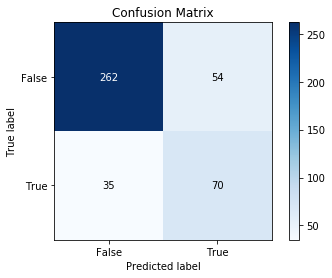

In [36]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df["actual"], df["predicted"], normalize=False )
plt.show()

/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


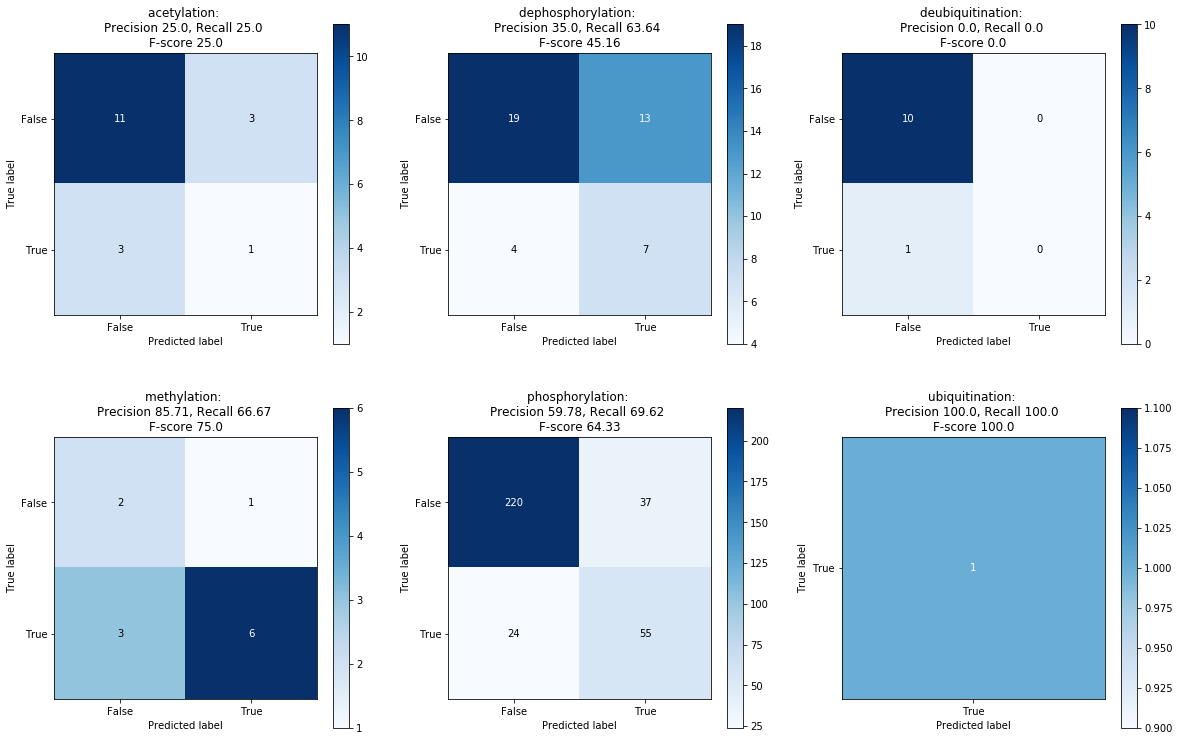

In [37]:
interactions = df["interactionType"].unique()
interactions.sort()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(3, 3)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    r = i//3
    c= i % 3
    df_interaction_type = df.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[r, c])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    precision= precision_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    recall = recall_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: \nPrecision {}, Recall {} \nF-score {}".format(interaction,  round(precision*100, 2),round(recall*100, 2), round(f1*100, 2)), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_.jpg", bbox_inches='tight')
plt.show()
    
    


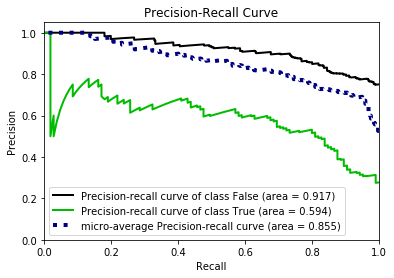

In [38]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df["actual"], df[["false", "true"]])

## Training / Validation epoch fit

In [39]:
import json
import pandas as pd
from pandas.io.json import json_normalize

def load_as_df (file):
    with open(file, "r") as i:
        data = json.loads(i.read())
        
    return json_normalize(data)
    

In [46]:
df_train_fit = load_as_df(train_fit_file)
df_train_fit["score"] =df_train_fit["score"]* 100
df_train_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
23,23,21.375647,80.780603
21,21,22.451559,80.187573
20,20,22.113240,80.117994
22,22,22.449327,79.589510
19,19,24.611177,77.777778
18,18,24.941987,76.435407
17,17,26.104884,72.844273
14,14,29.814315,67.980296
16,16,27.490403,67.872648
13,13,31.204962,64.671533


In [47]:
df_val_fit = load_as_df(validation_fit_file)
df_val_fit["score"] =df_val_fit["score"]* 100


df_val_fit.sort_values(["score"], ascending=False).head(n=10)

,epoch,loss,score
2,2,6.198084,61.135371
1,1,6.269503,60.792952
3,3,6.140175,59.330144
5,5,6.921479,59.227468
7,7,6.820877,57.142857
6,6,6.517490,56.281407
10,10,7.134496,55.837563
4,4,6.170561,54.639175
9,9,7.049595,53.191489
20,20,9.999211,52.682927


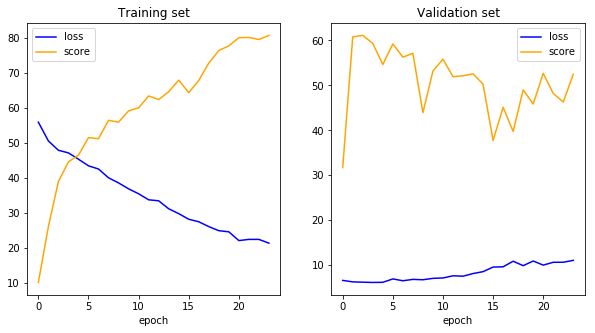

In [48]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

df_train_fit.plot.line(x="epoch", y="loss", ax = ax[0], color ="blue")
df_train_fit.plot.line(x="epoch", y="score", ax = ax[0], color="orange")
ax[0].set_title("Training set")
#ax[0].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))

df_val_fit.plot.line(x="epoch", y="loss", ax = ax[1], color="blue")
df_val_fit.plot.line(x="epoch", y="score", ax = ax[1], color ="orange")
ax[1].set_title("Validation set")
#ax[1].yaxis.set_major_locator(plt.FixedLocator([0,.1,.2,.3,.4,.5,.6, .7,.8,.9,1]))



plt.show()

### Threshold 

In [49]:
threshold = .75
df_trues = df.query("true > {}".format(threshold))
df_trues.shape

(156, 28)

In [50]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_trues["actual"], df_trues["predicted"])  
accuracy = accuracy_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)
precision = precision_score(df_trues["actual"], df_trues["predicted"], sample_weight=None)


print("The F1 score is {} and the accuracy is {}, precision {}".format(f1, accuracy, precision))

The F1 score is 0.6796116504854369 and the accuracy is 0.5769230769230769, precision 0.5645161290322581


phosphorylation
acetylation
dephosphorylation
methylation
ubiquitination
deubiquitination


/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/aeg/miniconda/envs/untitled2/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


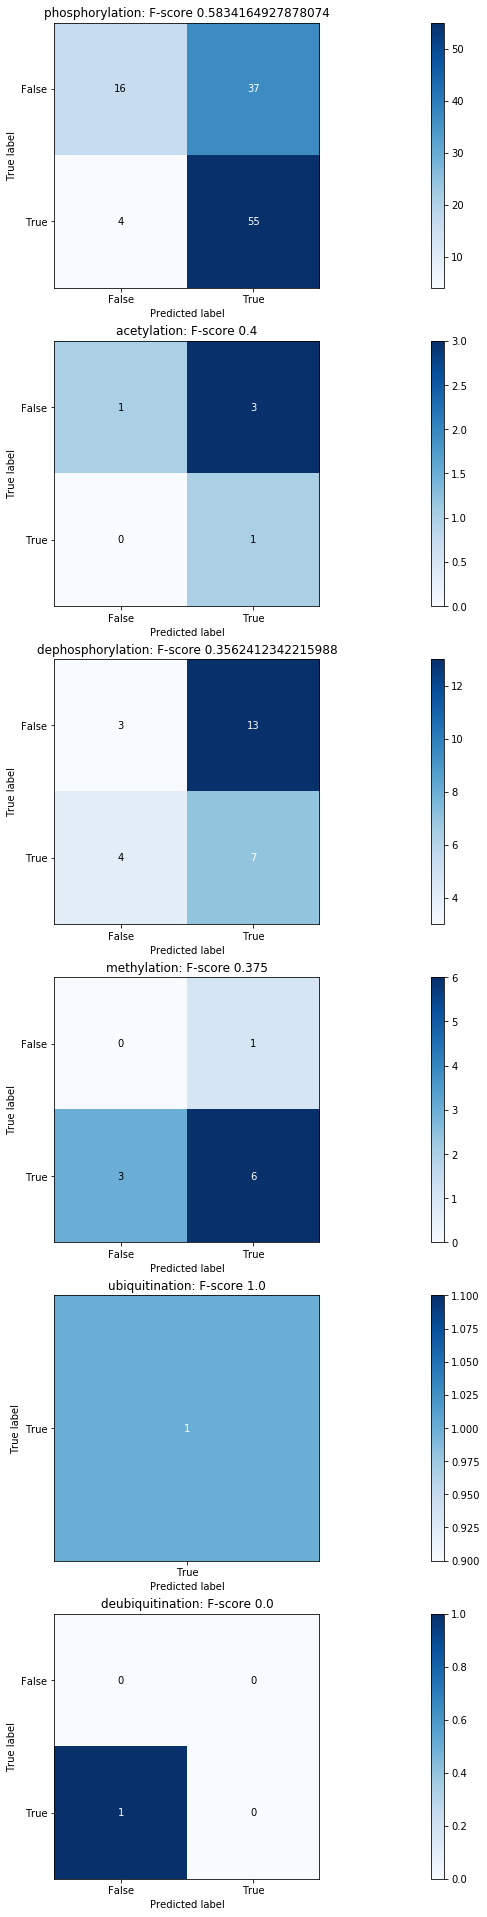

In [51]:
interactions = df_trues["interactionType"].unique()
#fig, ax = plt.subplots(1, len(interactions), figsize=(40,40), squeeze=False, sharey=True, sharex=True)
fig = plt.figure(figsize=(40,40))
gs = fig.add_gridspec(7, 1)
#ax = fig.add_axes([0,0,1,1])
i = 0
for interaction in interactions:
    print(interaction)
    df_interaction_type = df_trues.query("interactionType == '{}'".format(interaction))
    ax1 = fig.add_subplot(gs[i, 0])
    


    f1 = f1_score(df_interaction_type["actual"], df_interaction_type["predicted"], average='macro')  
    accuracy = accuracy_score(df_interaction_type["actual"], df_interaction_type["predicted"], sample_weight=None)
    skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax1)
    
#     ax2 = fig.add_subplot(gs[i, 1])
#     skplt.metrics.plot_confusion_matrix(df_interaction_type["actual"], df_interaction_type["predicted"], normalize=False, title = "{}: F-score {}".format(interaction,f1), ax= ax2)


    i += 1
    #break

plt.savefig("confusionmatrix_threshold.jpg", bbox_inches='tight')
plt.show()
    

## Filter uniprot not in train

In [52]:
df_train = pd.read_json('train_unique_pub_v6_less_negative.json')

In [54]:
df_train['participant1Id'].values.tolist()[0:10]

['O43293-1',
 'O60934',
 'P53667',
 'Q96EB6',
 'Q99558',
 'Q9Y6K9',
 'O15111',
 'P01375',
 'P01375',
 'O15111']

In [55]:
train_uniprot = set(df_train['participant1Id'].values.tolist()).union(set(df_train['participant2Id'].values.tolist()))

In [56]:
df_filtered_uniprot =df[ df.apply(lambda r : r['participant2Id'] in train_uniprot and  r['participant1Id'] in train_uniprot , axis=1)]

In [57]:
df_filtered_uniprot.shape

(208, 28)

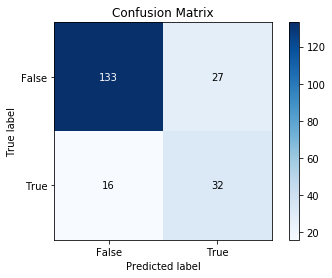

In [58]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], normalize=False )
plt.show()

In [59]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], sample_weight=None)  
accuracy = accuracy_score(df_filtered_uniprot["actual"], df_filtered_uniprot["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))




The F1 score is 0.5981308411214954 and the accuracy is 0.7932692307692307


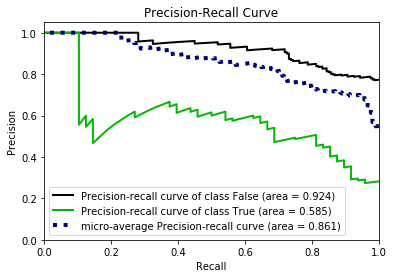

In [60]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_precision_recall(df_filtered_uniprot["actual"], df_filtered_uniprot[["false", "true"]])

#### Impact of missing uniprot

In [61]:
df_filtered_missing_uniprot =df[ df.apply(lambda r : r['participant2Id']  not in train_uniprot  or  r['participant1Id'] not in train_uniprot , axis=1)]

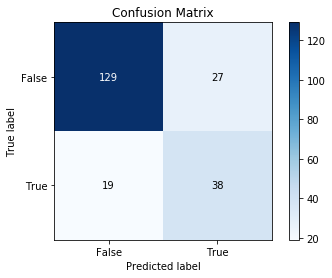

In [62]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(df_filtered_missing_uniprot["actual"], df_filtered_missing_uniprot["predicted"], normalize=False )
plt.show()

In [63]:
from sklearn.metrics import f1_score, accuracy_score

f1 = f1_score(df_filtered_missing_uniprot["actual"], df_filtered_missing_uniprot["predicted"], sample_weight=None)  
accuracy = accuracy_score(df_filtered_missing_uniprot["actual"], df_filtered_missing_uniprot["predicted"], sample_weight=None)
print("The F1 score is {} and the accuracy is {}".format(f1, accuracy))

The F1 score is 0.6229508196721312 and the accuracy is 0.784037558685446
